1 - bibliotecas

In [2]:
import os 
import shutil
import pathlib
import time
import datetime
from matplotlib import pyplot as plt 
from IPython import display
import tensorflow as tf
from tensorflow.keras.utils import plot_model

tf.random.set_seed(789)

2 - download do dataset

In [ ]:
dataset = 'maps'

arquivo_dataset = "{}.tar.gz".format(dataset)
url_dataset = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(arquivo_dataset)

download_zip = tf.keras.utils.get_file(fname= arquivo_dataset, origin = url_dataset, extract = True)

pastas = {
    "/Users/kyush/.keras/datasets/maps": "/Users/kyush/OneDrive/Documentos/projetos python/projetos_IA/CGAN - Pix2Pix - maps"
}

for antiga, nova in pastas.items():
    if os.path.exists(antiga):
        shutil.move(antiga, nova)
        print(f"Movido: {antiga} -> {nova}")
    else:
        print(f"Erro: A pasta '{antiga}' não existe.")

2.2 - visualização das imagens

(600, 1200, 3)


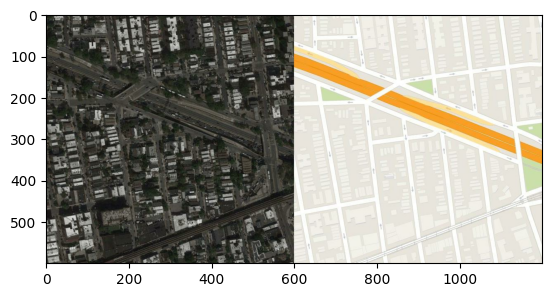

In [3]:
amostra = tf.io.read_file(str("maps/train/2.jpg"))
amostra = tf.io.decode_jpeg(amostra)

print(amostra.shape)
plt.figure()
plt.imshow(amostra)

3 - pré processamento das imagens

3.1 - separação das imagens

In [4]:
def carregar_imagem(img_arquivo):
    img = tf.io.read_file(img_arquivo)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, [256, 512])

    largura = tf.shape(img)[1]
    largura = largura // 2
    img_original = img[:, :largura, :]
    img_transformada = img[:, largura:, :]

    img_original = tf.cast(img_original, tf.float32)
    img_transformada = tf.cast(img_transformada, tf.float32)

    return img_original, img_transformada

3.1.1 - analise das imagens separadas

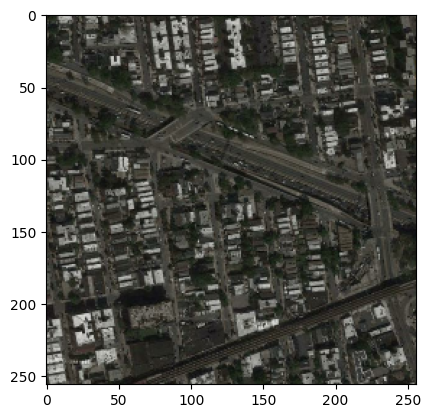

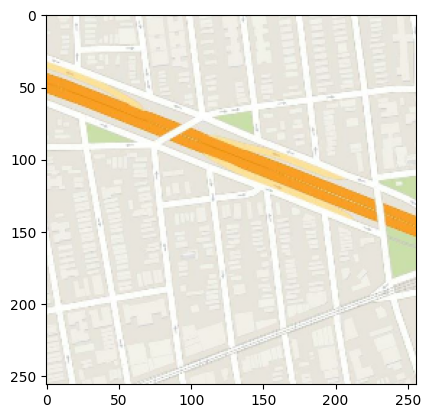

In [5]:
img_original, img_transformada = carregar_imagem(str("maps/train/2.jpg"))
plt.figure()
plt.imshow(img_original / 255.0)
plt.figure()
plt.imshow(img_transformada / 255.0)

3.2 - separação de imagens de treinamento

In [6]:
qtd_treinamento = tf.data.Dataset.list_files(str("maps/train/*.jpg"))
qtd_treinamento = len(list(qtd_treinamento))

3.3 - configurações do treinamento

In [7]:
buffer_size = qtd_treinamento
batch_size = 1
img_largura = 256
img_altura = 256

3.4 - função de redimensionamento

In [8]:
def redimensionar(img_original, img_transformada, altura, largura):
    img_original = tf.image.resize(img_original, [altura, largura], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img_transformada = tf.image.resize(img_transformada, [altura, largura], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img_original, img_transformada

3.5 - normalização dos pixels

In [9]:
def normalizar(img_original, img_transformada):
    img_original = (img_original / 127.5) - 1
    img_transformada = (img_transformada / 127.5) - 1

    return img_original, img_transformada

3.6 dimensionamento aleatorio

In [10]:
def crop_aleatorio(img_original, img_transformada):
    img_empilhada = tf.stack([img_original, img_transformada], axis=0)

    img_crop = tf.image.random_crop(img_empilhada, size = [2, img_altura, img_largura, 3])
    return img_crop[0], img_crop[1]

In [11]:
@tf.function()
def jitter_aleatorio(img_original, img_transformada):
    img_original, img_transformada = redimensionar(img_original, img_transformada, 286, 286)
    img_original, img_transformada = crop_aleatorio(img_original, img_transformada)

    if tf.random.uniform(()) > 0.5:
        img_original = tf.image.flip_left_right(img_original)
        img_transformada = tf.image.flip_left_right(img_transformada)
    
    return img_original, img_transformada

3.6.1 - visualização das imagens aleatorizadas

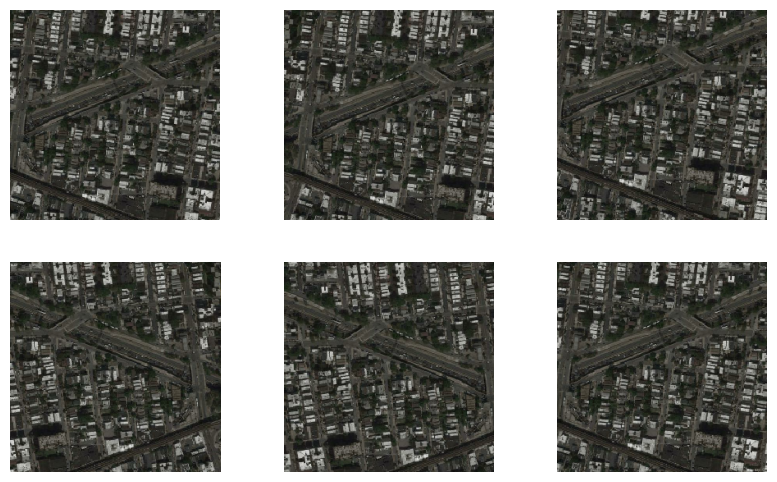

In [12]:
plt.figure(figsize=(10, 6))
for i in range(6):
    j_original, j_transformada = jitter_aleatorio(img_original, img_transformada)

    plt.subplot(2, 3, i + 1)
    plt.imshow(j_original / 255.0)
    plt.axis('off')
plt.show()

4 - carregamento dos dados de treinamento e validação

In [13]:
def carrega_img_treinamento(img_arquivo):
    img_original, img_transformada = carregar_imagem(img_arquivo)
    img_original, img_transformada = jitter_aleatorio(img_original, img_transformada)
    img_original, img_transformada = normalizar(img_original, img_transformada)
    return img_original, img_transformada

In [14]:
def carrega_img_teste(img_arquivo):
    img_original, img_transformada = carregar_imagem(img_arquivo)
    img_original, img_transformada = redimensionar(img_original, img_transformada, img_altura, img_largura)
    img_original, img_transformada = normalizar(img_original, img_transformada)
    return img_original, img_transformada

In [15]:
dataset_treinamento = tf.data.Dataset.list_files(str("maps/train/*.jpg"))
dataset_treinamento = dataset_treinamento.map(carrega_img_teste, num_parallel_calls=tf.data.AUTOTUNE)
dataset_treinamento = dataset_treinamento.shuffle(buffer_size)
dataset_treinamento = dataset_treinamento.batch(batch_size)

4.2 load do dataset

In [16]:
try:
    dataset_teste = tf.data.Dataset.list_files(str("maps/val/*.jpg"))
except tf.errors.InvalidArgumentError:
    dataset_teste = tf.data.Dataset.list_files(str("maps/test/*.jpg"))

dataset_teste = dataset_teste.map(carrega_img_teste)
dataset_teste = dataset_teste.batch(batch_size)

5 - desenvolvimento do Gerador baseado na U-Net(muito utilizado na pix2pix)

5.1 - função de downsample(encoder)

In [17]:
def encode(filters, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0, 0.02)
    resultado = tf.keras.Sequential()
    resultado.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))

    if apply_batchnorm:
        resultado.add(tf.keras.layers.BatchNormalization())
        
    resultado.add(tf.keras.layers.LeakyReLU())

    return resultado


5.1.1 - teste do encode

In [18]:
down_model = encode(3,4)
down_result = down_model(tf.expand_dims(img_original, 0))
print(down_result.shape)



(1, 128, 128, 3)


5.2 - função de upsample(decode)

In [19]:
def decode(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0, 0.02)
    resultado = tf.keras.Sequential()
    resultado.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same', 
                                         kernel_initializer = initializer, use_bias = False))

    resultado.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        resultado.add(tf.keras.layers.Dropout(0.5))
        
    resultado.add(tf.keras.layers.ReLU())

    return resultado

5.2.1 - teste do decode

In [20]:
up_model = decode(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


5.3 - arquitetura do gerador

In [21]:
def Gerador():
    inputs = tf.keras.layers.Input(shape = [256, 256, 3])

    downsampling = [
        encode(64, 4, apply_batchnorm=False),
        encode(128, 4),
        encode(256, 4),
        encode(512, 4),
        encode(512, 4),
        encode(512, 4),
        encode(512, 4),
        encode(512, 4)
    ]

    upsampling = [
        decode(512, 4, apply_dropout=True),
        decode(512, 4, apply_dropout=True),
        decode(512, 4, apply_dropout=True),
        decode(512, 4),
        decode(256, 4),
        decode(128, 4),
        decode(64, 4)
    ]

    canais_saida = 3
    initializer = tf.random_normal_initializer(0.,0.02)
    last = tf.keras.layers.Conv2DTranspose(canais_saida, 4, strides = 2, padding='same',
                                           kernel_initializer = initializer, activation='tanh')
    
    x = inputs
    skips = []

    for down in downsampling:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])

    for up, skip in zip(upsampling, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs = inputs, outputs = x)

5.3.1 - analisando a arquitetura

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999976..1.0].


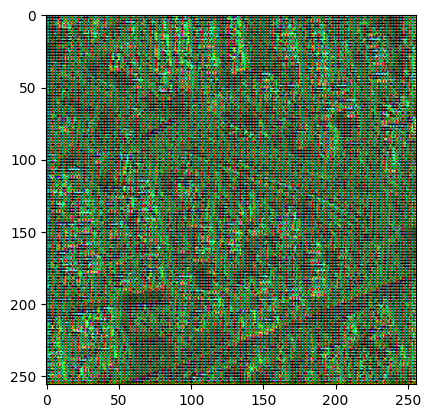

In [22]:
gerador = Gerador()
tf.keras.utils.plot_model(gerador, show_shapes = True, dpi = 64)

g_saida = gerador(img_original[tf.newaxis, ...], training=False)
plt.imshow(g_saida[0, ...])

5.4 - função de perca do gerador

5.4.1 - criação dos hiperparametros

In [23]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

5.4.2 - função de perda do gerador

In [ ]:
def loss_gerador(d_saida_gerada, g_saida, target):
    gan_loss = loss(tf.ones_like(d_saida_gerada), d_saida_gerada)
    l1_loss = tf.reduce_mean(tf.abs(target - g_saida))
    g_loss_total = gan_loss + (lambda_ * l1_loss)
    
    return g_loss_total, gan_loss, l1_loss

6 - desenvolvimento do Discriminador utilizando o modelo patchGAN muito comum no Pix2Pix

6.1 - funçaõ do descriminador

In [25]:
def Discriminador():
    initializer = tf.random_normal_initializer(0., 0.02)

    original = tf.keras.layers.Input(shape = [256, 256,3], name='img_original')
    transformada = tf.keras.layers.Input(shape = [256, 256,3], name='img_transformada')
    x = tf.keras.layers.concatenate([original, transformada])

    down1 = encode(64, 3, False)(x)
    down2 = encode(128, 4)(down1)
    down3 = encode(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer = initializer, 
                                  use_bias = False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides= 1, kernel_initializer = initializer)(zero_pad2)

    return tf.keras.Model(inputs = [original, transformada], outputs = last)


6.1.1 - teste da função

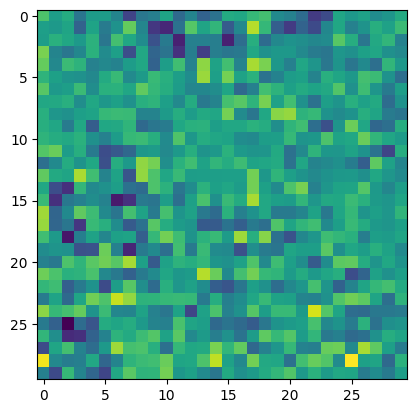

In [26]:
discriminador = Discriminador()
tf.keras.utils.plot_model(discriminador, show_shapes= True, dpi=64)

d_saida = discriminador([img_original[tf.newaxis, ...], g_saida], training=False)
plt.imshow(d_saida[0, ..., -1])

6.2 - função da perda do descriminador

In [27]:
def loss_discriminador(d_saida_real, d_saida_gerada):
  loss_real = loss(tf.ones_like(d_saida_real), d_saida_real)
  loss_gerada = loss(tf.zeros_like(d_saida_gerada), d_saida_gerada)
  d_loss_total = loss_real + loss_gerada
  
  return d_loss_total

7 - criação do optimizer

In [28]:
optimizer_gerador = tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)
optimizer_discriminador = tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)

8 - checkpoint

In [29]:
if not os.path.exists("checkpoint"):
    os.makedirs("checkpoint")


checkpoint_dir = "checkpoint"
checkpoint_prefixo = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = optimizer_gerador,
                                 discriminator_optimizer = optimizer_discriminador,
                                 generator = gerador,
                                 discriminator = discriminador)

9 - geração das imagens

In [30]:
def gerar_imagens(modelo, teste_entrada, real, etapa=None):
    gerada = modelo(teste_entrada, training=True)
    plt.figure(figsize=(12,8))

    lista_imgs = [teste_entrada[0], real[0], gerada[0]]
    titulo = ['imagem de entrada', 'Real(ground truth)',' imagem gerada']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titulo[i])
        plt.imshow(lista_imgs[i]* 0.5 + 0.5)
        plt.axis('off')

    if not os.path.exists("resultados"):
        os.makedirs("resultados")

    if etapa is not None:
        plt.savefig('resultados/resultado_pix2pix_etapa_{}.png'.format(etapa), bbox_inches = 'tight')

    plt.show()

9.1 - teste da geração

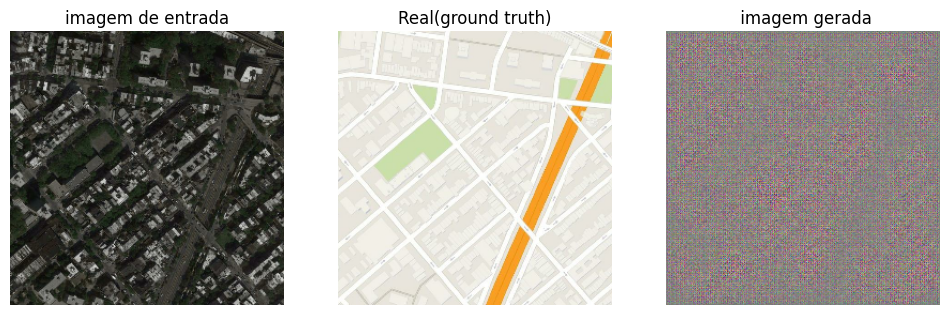

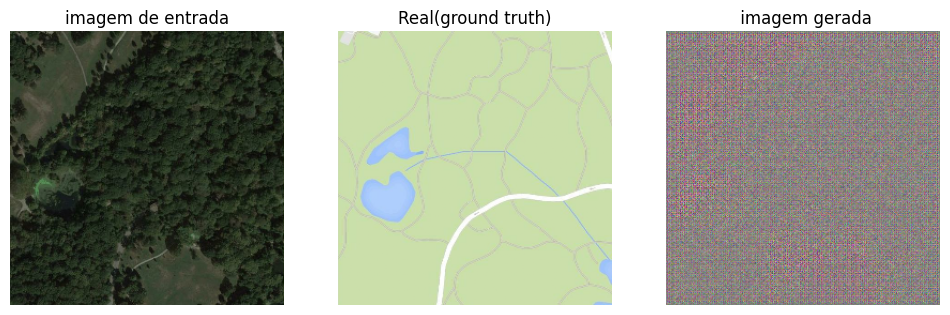

In [31]:
for entrada_exemplo, real_exemplo in dataset_teste.take(2):
    gerar_imagens(gerador, entrada_exemplo, real_exemplo)

10 - treinamento

10.1 - arquivamento dos logs

In [32]:
if not os.path.exists("log"):
    os.makedirs("log")
caminho_log = 'log/'
metricas = tf.summary.create_file_writer(caminho_log + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

10.2 - função de etapas de treinamento

In [33]:
#@tf.function
def etapa_treinamento(img_entrada, real, etapa):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_saida = gerador(img_entrada, training = True)

    d_saida_real = discriminador([img_entrada, real], training = True)
    d_saida_gerada = discriminador([img_entrada, g_saida], training = True)

    g_loss_total, g_loss_gan, g_loss_l1 = loss_gerador(d_saida_gerada, g_saida, real)
    d_loss = loss_discriminador(d_saida_real, d_saida_gerada)

  gradients_gerador = g_tape.gradient(g_loss_total, gerador.trainable_variables)
  gradients_discriminador = d_tape.gradient(d_loss, discriminador.trainable_variables)

  optimizer_gerador.apply_gradients(zip(gradients_gerador, gerador.trainable_variables))
  optimizer_discriminador.apply_gradients(zip(gradients_discriminador, discriminador.trainable_variables))

  with metricas.as_default():
    tf.summary.scalar('g_loss_total', g_loss_total, step=etapa//1000)
    tf.summary.scalar('g_loss_gan', g_loss_gan, step=etapa//1000)
    tf.summary.scalar('g_loss_l1', g_loss_l1, step=etapa//1000)
    tf.summary.scalar('d_loss', d_loss, step=etapa//1000)

10.3 - função de treinamento

In [34]:
def treinar(base_treinamento, base_teste, etapas):
  entrada_exemplo, exemplo_real = next(iter(base_teste.take(1)))
  inicio = time.time()

  for etapa, (img_entrada, real) in base_treinamento.repeat().take(etapas).enumerate():
    if etapa % 1000 == 0:
      display.clear_output(wait = True)
      if etapa != 0:
        print(f'Tempo para executar 1000 etapas: {time.time() - inicio:.2f} segundos\n')
      inicio = time.time()
      gerar_imagens(gerador, entrada_exemplo, exemplo_real, etapa)
      print(f"Etapa: {etapa//1000}K")
    etapa_treinamento(img_entrada, real, etapa)
    if (etapa + 1) % 10 == 0:
      print('.', end = '', flush = True)
    if (etapa + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefixo)
      gerador.save_weights('modelo_pix2pix.h5')

10.4 - treinamento 

Tempo para executar 1000 etapas: 790.53 segundos



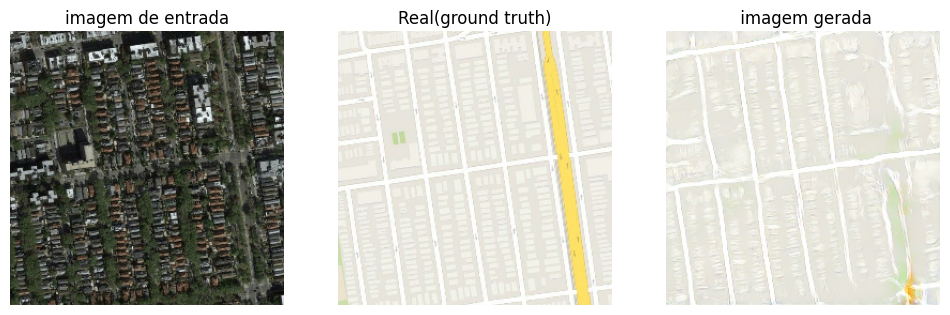

Etapa: 39K
....................................................................................................

In [230]:
treinar(dataset_treinamento, dataset_teste, etapas = 40000)

11 - restauração dos checkpoints

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

modelo_pretreinado = Gerador()
modelo_pretreinado.load_weights('modelo_pix2pix.h5')

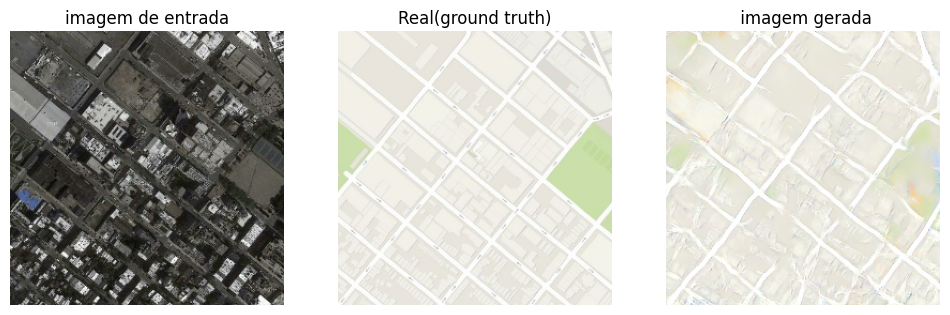

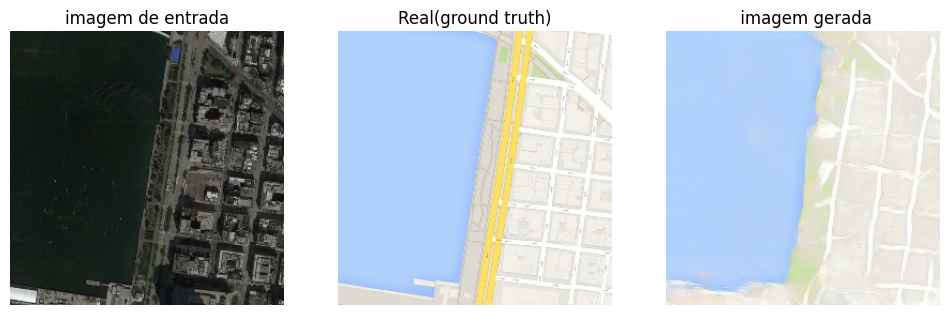

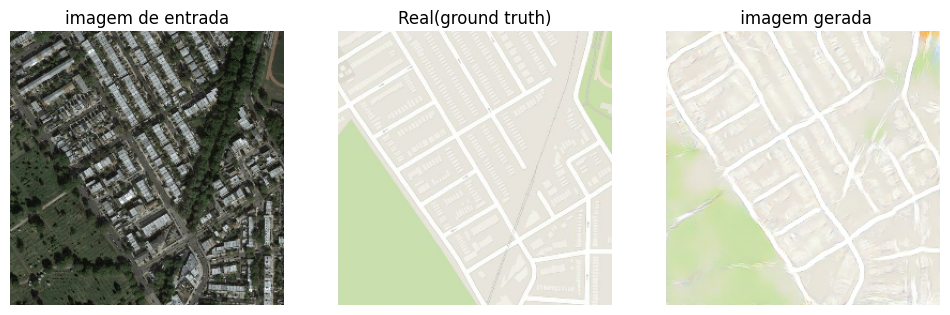

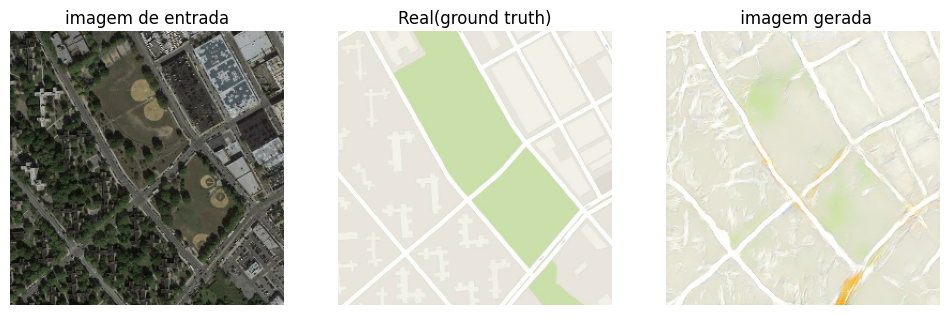

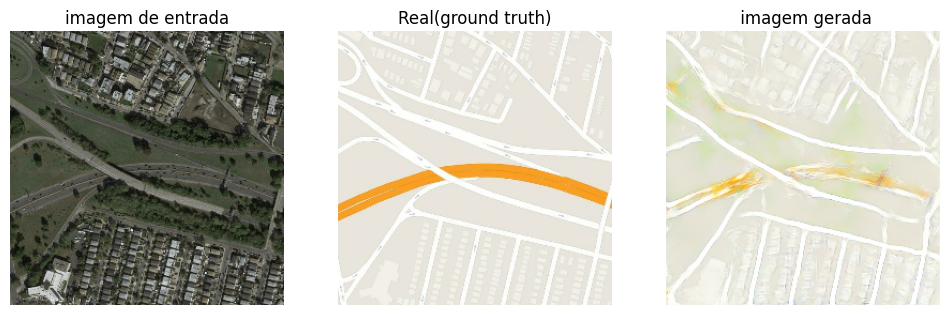

In [36]:
for satelite, mapa in dataset_teste.take(5):
    gerar_imagens(modelo_pretreinado, satelite, mapa)